In [1]:
! nvidia-smi

Wed Nov 24 12:57:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install fastai --upgrade

     |████████████████████████████████| 189 kB 12.5 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
import fastai
from fastai.vision.all import *

In [4]:
!pip install -q jmd_imagescraper

In [5]:
from jmd_imagescraper.core import *
from pathlib import Path

In [6]:
n_images = 100
search_terms = ["black bear", "grizzly bear", "teddy bear"]

In [7]:
path = Path.cwd()/"test_images"

In [8]:
if path.exists():
  import shutil 
  shutil.rmtree(path)

In [9]:
for term in search_terms :
  duckduckgo_search(path, '_'.join(term.split()), term, max_results= n_images)

Duckduckgo search: black bear


Duckduckgo search: grizzly bear


Duckduckgo search: teddy bear


In [24]:
bears = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  get_y = parent_label, 
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 260),
                  item_tfms = (Resize(240)))

In [17]:
path.ls()

(#3) [Path('/content/test_images/grizzly_bear'),Path('/content/test_images/black_bear'),Path('/content/test_images/teddy_bear')]

In [25]:
dls = bears.dataloaders(path)

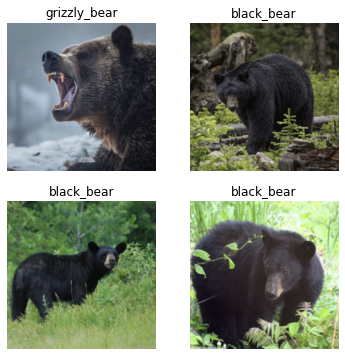

In [26]:
dls.show_batch(max_n = 4)

In [10]:
def get_y(r):
  return [Path(r).parent.name]

In [11]:
bears = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                  get_items = get_image_files,
                  get_y = get_y,
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 250),
                  item_tfms = Resize(460),
                  batch_tfms = aug_transforms(size = 240, min_scale = 0.75))

In [12]:
dls = bears.dataloaders(path, device = "cuda")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


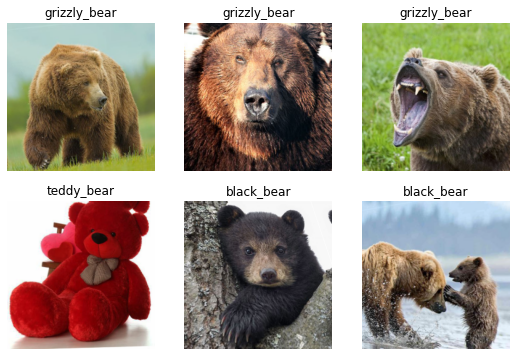

In [13]:
dls.show_batch(max_n = 6)

In [14]:
dls.vocab

['black_bear', 'grizzly_bear', 'teddy_bear']

In [17]:
x, y = dls.train.one_batch()

In [18]:
x.shape

torch.Size([64, 3, 240, 240])

In [19]:
y[0]

TensorMultiCategory([1., 0., 0.], device='cuda:0')

In [20]:
def accuracy_multi(inp, targets, thresh = 0.5, sigmoid = True):
  if sigmoid :
    inp = inp.sigmoid()
  return ((inp>thresh) == targets.bool()).float().mean()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0003981071640737355)

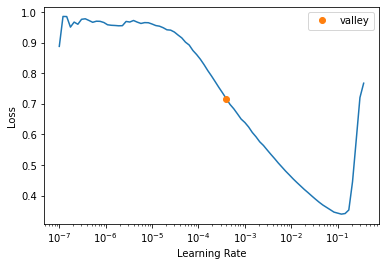

In [63]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi,thresh = 0.7))

learn.lr_find()

In [64]:
learn.fit_one_cycle(n_epoch = 5, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.649213,0.106486,0.938889,00:09
1,0.370668,0.103592,0.961111,00:07
2,0.265592,0.121474,0.944444,00:07
3,0.209641,0.137193,0.944444,00:07
4,0.176320,0.091921,0.966667,00:07


In [48]:
learn.fit_one_cycle(n_epoch = 5, lr_max=0.0003981071640737355)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.395307,2.403865,0.750000,00:04
1,0.392296,1.349335,0.822222,00:04
2,0.400235,0.894340,0.866667,00:04
3,0.414372,0.693599,0.866667,00:04
4,0.389492,0.578361,0.877778,00:04


In [65]:
learn.fine_tune(epochs = 10, base_lr = 0.0003981071640737355, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027684,0.062519,0.977778,00:07
1,0.021839,0.055575,0.983333,00:07
2,0.019594,0.057306,0.972222,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.013305,0.056811,0.972222,00:09
1,0.023451,0.055618,0.977778,00:08
2,0.031302,0.056630,0.977778,00:08
3,0.031194,0.059745,0.977778,00:08
4,0.028730,0.067272,0.977778,00:08
5,0.026752,0.073900,0.972222,00:08
6,0.025985,0.081517,0.966667,00:08
7,0.023589,0.080694,0.966667,00:08
8,0.021857,0.081818,0.961111,00:08
9,0.022233,0.085938,0.961111,00:08


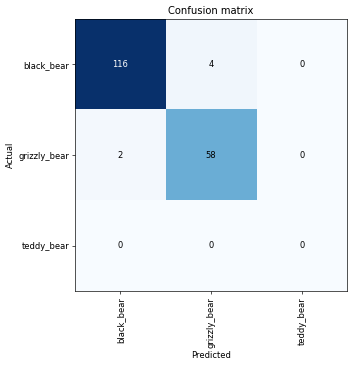

In [66]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize = (6, 6), dpi = 60)

In [68]:
interp.most_confused(min_val = 3)

[('black_bear', 'grizzly_bear', 4)]

In [74]:
learn.fit_one_cycle(n_epoch = 4, lr_max = slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.016209,0.091086,0.961111,00:07
1,0.010940,0.079322,0.983333,00:07
2,0.020143,0.098432,0.977778,00:07
3,0.019183,0.084839,0.977778,00:07


In [75]:
preds, targets = learn.get_preds()

In [76]:
preds[0]

TensorBase([0.0069, 0.0079, 1.0000])

In [77]:
xs = torch.linspace(0.05, 0.95, 30)

In [78]:
acc = [accuracy_multi(preds, targets, i, sigmoid = False) for i in xs]

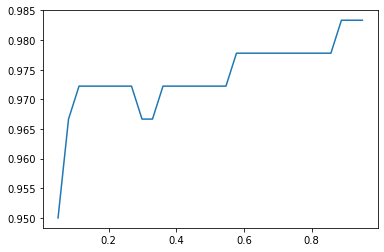

In [79]:
plt.plot(xs, acc)

In [19]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi,thresh = 0.99), loss_func=BCEWithLogitsLossFlat(thresh = 0.95))

learn.fit_one_cycle(5, lr_max = slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.681331,0.696073,0.933333,00:07
1,0.415848,0.255781,0.983333,00:07
2,0.324810,0.148385,0.977778,00:07
3,0.272708,0.100835,0.977778,00:07
4,0.229010,0.074582,0.977778,00:07


In [41]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi,thresh = 0.99), loss_func=BCEWithLogitsLossFlat(thresh = 0.95))

learn.fine_tune(epochs = 5, base_lr = 2e-3, freeze_epochs = 3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.767028,0.374751,0.666667,00:07
1,0.537376,0.225510,0.938889,00:07
2,0.420755,0.145136,0.966667,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.162114,0.172498,0.966667,00:11
1,0.130227,0.133419,0.961111,00:08
2,0.105343,0.078318,0.955556,00:08
3,0.085658,0.080188,0.955556,00:08
4,0.072937,0.083004,0.955556,00:08


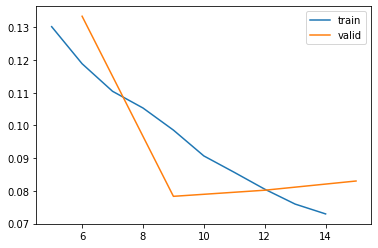

In [42]:
learn.recorder.plot_loss()

In [22]:
learn.predict("/content/download.jfif")

((#0) [],
 TensorBase([False, False, False]),
 TensorBase([0.0027, 0.2055, 0.8062]))

In [27]:
learn.predict("/content/plot_july (12).png")

((#0) [],
 TensorBase([False, False, False]),
 TensorBase([0.1611, 0.0283, 0.1281]))

In [23]:
import ipywidgets as widgets

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [26]:
btn_upload.data[-1]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x10\x12\x10\x12\x12\x15\x10\x10\x15\x15\x15\x10\x15\x10\x15\x10\x17\x12\x15\x15\x15\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383,7(-.+\x01\n\n\n\r\r\x0e\x15\x10\x10\x15-\x1d\x17\x1d+--++-+-+.++---++++++--+-++----++--++-7-+2+++++7++\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x01\x02\x05\x04\x06\x07\xff\xc4\x009\x10\x00\x01\x03\x02\x03\x05\x07\x02\x06\x01\x03\x05\x00\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121\x05AQaq\x13"\x81\x91\xa1\xb1\xc1\xd1\xf0\x06\x142BR\xe1b#3r\x15\x82\x92\xa2\xb2\xff\xc4\x00\x17\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xc4\x00\x1a\x11\x01\x01\x01\x00\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11\x01\x121\x91\x02\xff\xda\x00\x0c\x03\x01\x00\x02\

In [27]:
img = PILImage.create(btn_upload.data[-1])

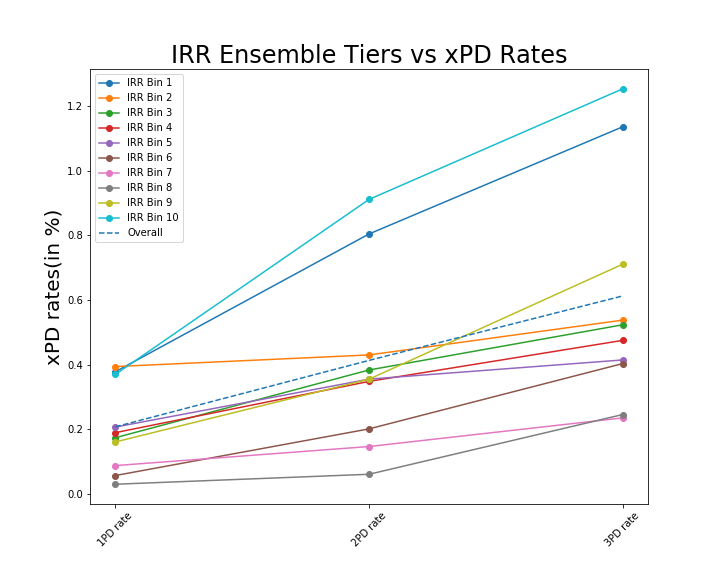

In [33]:
img

In [28]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl :
  display(img.to_thumb(128,128))

out_pl

Output()

In [29]:
pred = learn.predict(img)

In [30]:
print (pred[0], pred[1], pred[2])

[] TensorBase([False, False, False]) TensorBase([0.0027, 0.2055, 0.8062])


In [31]:
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction = {pred[0]}; Probability = {pred[2]}"

In [32]:
lbl_pred

Label(value='Prediction = []; Probability = TensorBase([0.0027, 0.2055, 0.8062])')

In [33]:
btn_run = widgets.Button(description = "Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
lbl_pred.value

'Prediction = []; Probability = TensorBase([0.0027, 0.2055, 0.8062])'

In [35]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output() 
  with out_pl :  display(img.to_thumb(128, 128))
  pred_label, _,preds  = learn.predict(img)
  lbl_pred.value = f"Prediction = {pred_label}; Probability = {preds}"

In [36]:
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
btn_run.on_click(on_click_classify)

In [40]:
out_pl

Output()

In [38]:
from ipywidgets import *

In [39]:
VBox([widgets.Label("Classify Bears"), btn_upload, btn_run,out_pl ,lbl_pred])